# 데이터 확인

In [1]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
from konlpy.tag import Okt


okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)      
        res = []
        for w in words:
            if w[1] in ["Noun"]:      
                res.append(w[0]) 
        tokenized.append(res)

In [3]:
print(len(tokenized))

71156


In [4]:
tokenized[:10]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌']]

# STEP 2. 추출된 결과로 embedding model 만들기

In [6]:
from gensim.models import Word2Vec

model = Word2Vec(tokenized, vector_size=100, window=5, min_count=5, workers=4, sg=0)

In [8]:
model.wv.most_similar("사운드")

[('기법', 0.9633674621582031),
 ('텍스트', 0.9627128839492798),
 ('내러티브', 0.9593825340270996),
 ('인상', 0.9518807530403137),
 ('요소', 0.9518207311630249),
 ('편집', 0.951572060585022),
 ('내레이션', 0.9515145421028137),
 ('대사', 0.9506202340126038),
 ('혼합', 0.9493817090988159),
 ('흑백', 0.948732316493988)]

In [9]:
model.wv.most_similar("시절")

[('유년', 0.8298842310905457),
 ('추억', 0.7894887924194336),
 ('회상', 0.7170544266700745),
 ('사춘기', 0.6901322603225708),
 ('안고', 0.6845101118087769),
 ('어머니', 0.6764124631881714),
 ('나이', 0.6757517457008362),
 ('현재', 0.6727810502052307),
 ('기억', 0.6706520915031433),
 ('학번', 0.6585559248924255)]

# STEP 3. target, attribute 단어 셋 만들기

In [10]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt


def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME') + '/aiffel/weat/' + file_name, 'r') as fread: 
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [11]:
art = read_token('synopsis_art.txt')
gen = read_token('synopsis_gen.txt')

In [12]:
len(art), len(gen)

(620208, 3014815)

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

X.shape

(2, 41082)

In [14]:
m1 = X[0].tocoo()
m2 = X[1].tocoo()

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)
w2.sort(key=lambda x: x[1], reverse=True) 

In [15]:
print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

In [16]:
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [17]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

In [18]:
len(w1_), len(w2_)

(100, 100)

In [19]:
target_art = []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 
        
target_art

['아빠',
 '음악',
 '결심',
 '운명',
 '지금',
 '여인',
 '이름',
 '이후',
 '준비',
 '감정',
 '만난',
 '처음',
 '충격',
 '누구',
 '그린']

In [20]:
target_gen = []
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break
        
target_gen

['서울',
 '애니메이션',
 '여성',
 '가지',
 '주인공',
 '대해',
 '연출',
 '사회',
 '다큐멘터리',
 '부문',
 '섹스',
 '바로',
 '의도',
 '계획',
 '정체']

In [21]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [22]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

In [23]:
len(genre)

21

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

X.shape

(21, 42191)

In [25]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 헨리, 마을, 자신, 아이, 시작, 무법자, 프린트, 마적, 현상금, 분노, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작,

# STEP 4. WEAT score 계산과 시각화

In [41]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

In [42]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X - mean_Y) / std_dev

In [43]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [44]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [45]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.4762627
SF 공연 -0.34787375
SF 공포(호러) -0.6294131
SF 기타 0.37308314
SF 다큐멘터리 0.5919088
SF 드라마 -0.36406654
SF 멜로로맨스 -0.7806728
SF 뮤지컬 0.31645793
SF 미스터리 -0.66681683
SF 범죄 -0.2234113
SF 사극 -0.84156233
SF 서부극(웨스턴) -0.48319724
SF 성인물(에로) -0.54535156
SF 스릴러 -0.5125577
SF 애니메이션 0.404968
SF 액션 -0.42666173
SF 어드벤처 -0.7355045
SF 전쟁 0.27006558
SF 코미디 -0.41146478
SF 판타지 -0.17317797
가족 공연 0.17127143
가족 공포(호러) -0.14508808
가족 기타 0.76840717
가족 다큐멘터리 0.8264643
가족 드라마 0.17910516
가족 멜로로맨스 -0.6293816
가족 뮤지컬 0.6635698
가족 미스터리 -0.31064323
가족 범죄 0.18931223
가족 사극 -0.16679595
가족 서부극(웨스턴) 0.22445752
가족 성인물(에로) -0.31042084
가족 스릴러 -0.14942813
가족 애니메이션 0.8909356
가족 액션 0.110049404
가족 어드벤처 -0.027732288
가족 전쟁 0.64383894
가족 코미디 0.17916702
가족 판타지 0.41337967
공연 공포(호러) -0.22392853
공연 기타 0.9765514
공연 다큐멘터리 0.9329055
공연 드라마 -0.027340429
공연 멜로로맨스 -0.7071495
공연 뮤지컬 0.8656878
공연 미스터리 -0.3511689
공연 범죄 0.06871076
공연 사극 -0.45347285
공연 서부극(웨스턴) -0.03683018
공연 성인물(에로) -0.4661334
공연 스릴러 -0.21910639
공연 애니메이션 0.94938403
공연 액션 -

<AxesSubplot:>

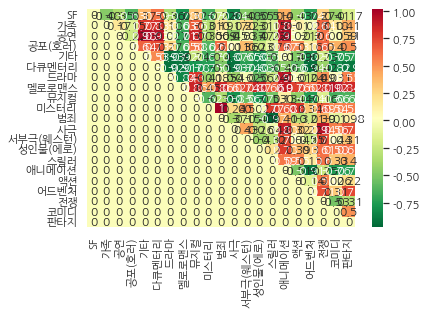

In [46]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

sns.set(font='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax